In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
# Restart the runtime
from google.colab import runtime
runtime.unassign()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Step 1: Mount Google Drive and imports
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, Reshape,
    MultiHeadAttention, Conv2D, BatchNormalization, MaxPooling2D, Input,
    Add, Activation
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import pickle
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Create test directory if it doesn't exist
test_dir = "/content/drive/My Drive/AST_Project/test"
os.makedirs(test_dir, exist_ok=True)

# Step 2: Load Preprocessed AST Features
with open("/content/drive/My Drive/AST_Project/ast_features.pkl", "rb") as f:
    ast_features, labels = pickle.load(f)

# Step 3: Convert Labels to Categorical
num_classes = len(np.unique(labels))
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(ast_features, labels, test_size=0.2, random_state=42)

# Step 5: Preprocess Data with consistent dimensions
def preprocess_data(X, sequence_length=250):
    X = np.transpose(X, (0, 2, 1))[:, :sequence_length, :]
    X = np.expand_dims(X, axis=-1)
    # Normalize features
    mean = np.mean(X, axis=(1,2), keepdims=True)
    std = np.std(X, axis=(1,2), keepdims=True)
    X = (X - mean) / (std + 1e-8)
    return X

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

# Save Test Data to test subdirectory
np.save(f"{test_dir}/X_test.npy", X_test)
np.save(f"{test_dir}/y_test.npy", y_test)

# Step 6: Corrected Model Architecture
def convolutional_frontend(inputs):
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Reshape((-1, 128))(x)  # Explicit output dimension
    return x

def transformer_block(x, num_heads=4, key_dim=128):
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim
    )(x, x)
    x = LayerNormalization()(x + attn_output)

    ffn_output = Dense(key_dim * 4, activation='relu')(x)
    ffn_output = Dropout(0.2)(ffn_output)
    ffn_output = Dense(key_dim)(ffn_output)
    x = LayerNormalization()(x + ffn_output)
    return x

def create_ast_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = convolutional_frontend(inputs)

    for _ in range(2):
        x = transformer_block(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    return model

# Step 7: Training Process
input_shape = X_train.shape[1:]
model = create_ast_model(input_shape, num_classes)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint(
        f"{test_dir}/best_ast_model.keras",
        monitor='val_accuracy',
        save_best_only=True
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Step 8: Save and Evaluate
model.save(f"{test_dir}/ast_transformer_model_final.keras")
history_df = pd.DataFrame(history.history)
history_df.to_csv(f"{test_dir}/training_history.csv", index=False)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Save predictions
y_pred = model.predict(X_test)
np.save(f"{test_dir}/y_pred.npy", y_pred)

Mounted at /content/drive
Epoch 1/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 147s 249ms/step - accuracy: 0.2079 - loss: 2.5312 - val_accuracy: 0.1757 - val_loss: 2.6023 - learning_rate: 0.0010
Epoch 2/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 59s 136ms/step - accuracy: 0.3844 - loss: 1.8062 - val_accuracy: 0.5049 - val_loss: 1.4837 - learning_rate: 0.0010
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.4893 - loss: 1.5308 - val_accuracy: 0.5089 - val_loss: 1.4941 - learning_rate: 0.0010
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.5403 - loss: 1.3276 - val_accuracy: 0.5707 - val_loss: 1.2725 - learning_rate: 0.0010
Epoch 5/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.6038 - loss: 1.1784 - val_accuracy: 0.5804 - val_loss: 1.2359 - learning_rate: 0.0010
Epoch 6/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.6382 - loss: 1.1040 - val_accuracy: 0.6548 - val_loss: 1.0124 - learning_rate: 0.0010
Epoch 7/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 60s

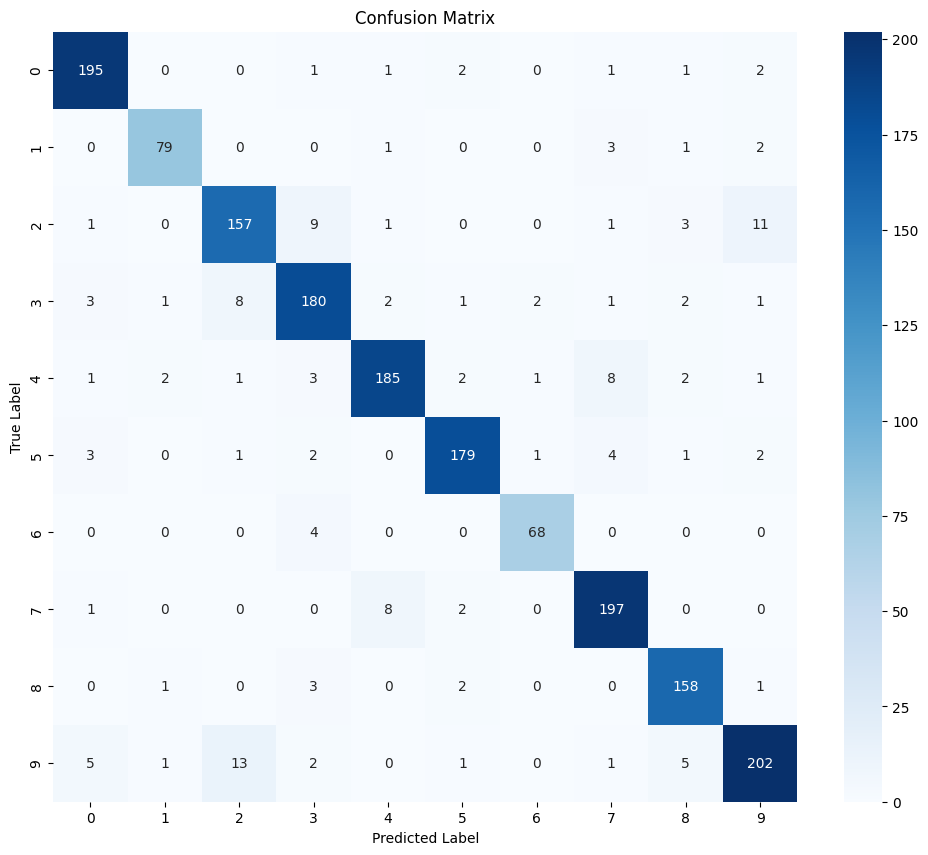

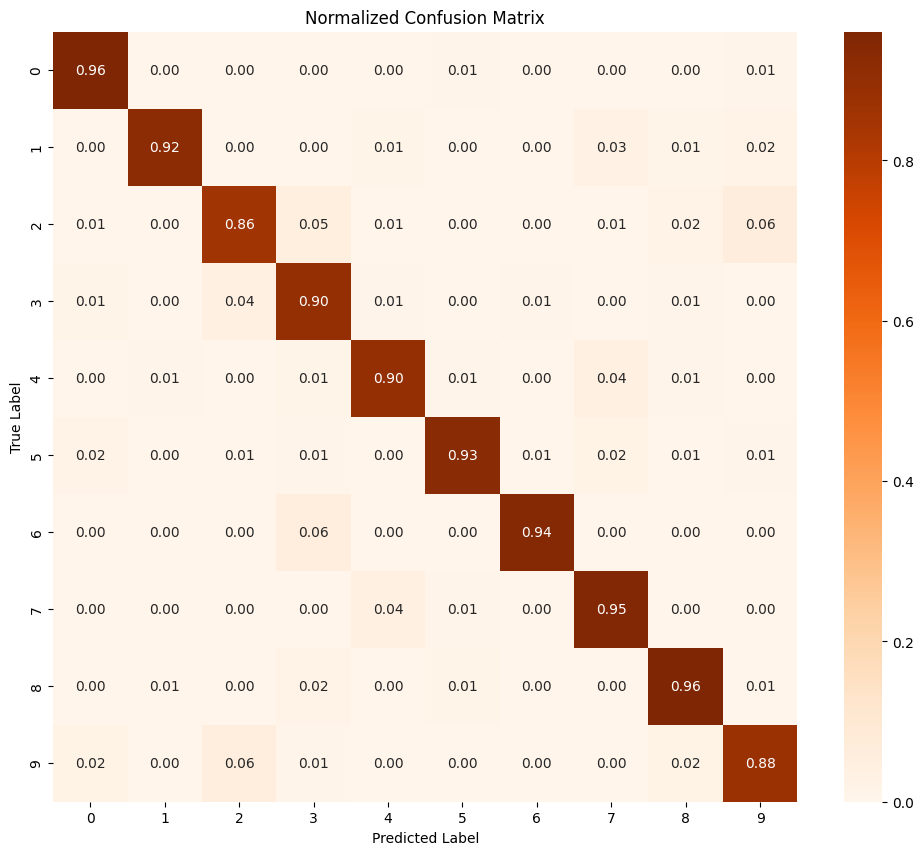

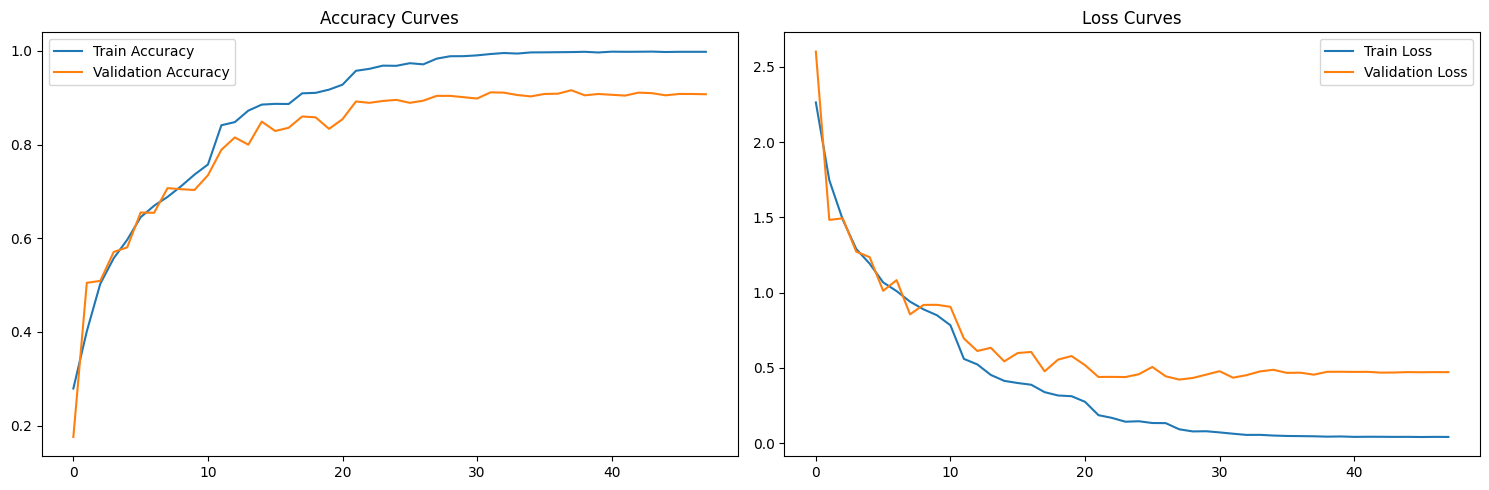

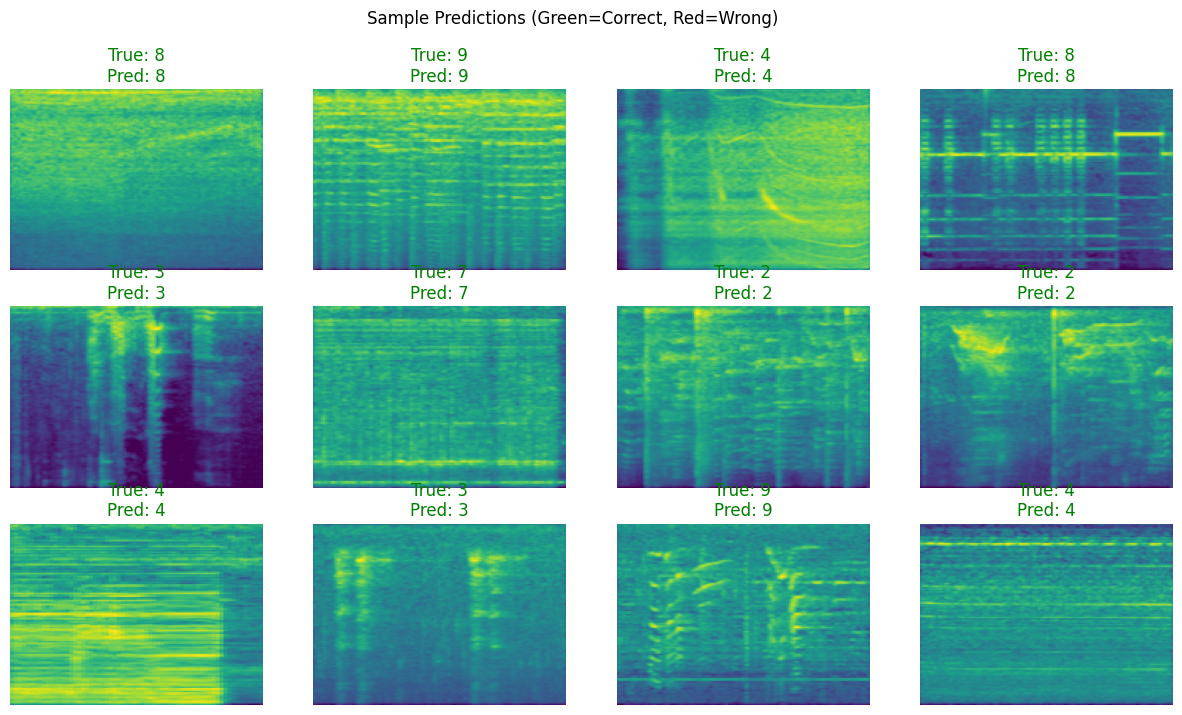

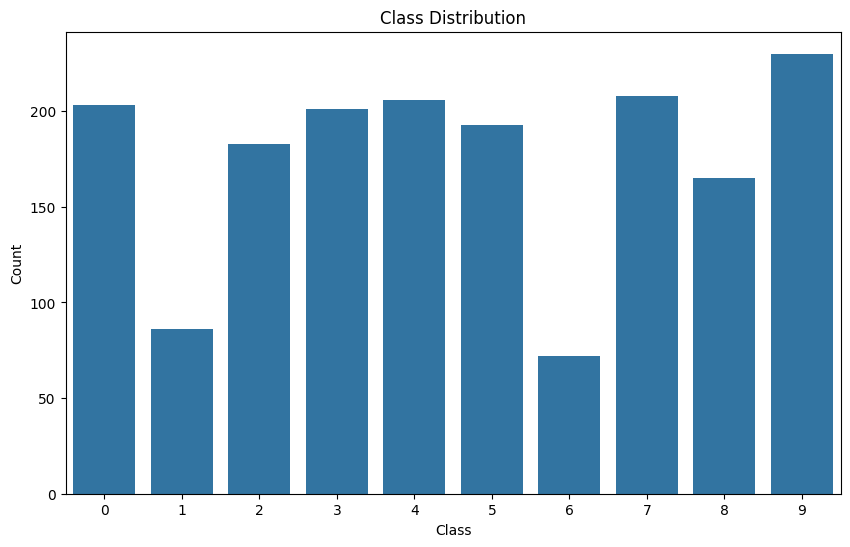

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       203
           1       0.94      0.92      0.93        86
           2       0.87      0.86      0.87       183
           3       0.88      0.90      0.89       201
           4       0.93      0.90      0.92       206
           5       0.95      0.93      0.94       193
           6       0.94      0.94      0.94        72
           7       0.91      0.95      0.93       208
           8       0.91      0.96      0.93       165
           9       0.91      0.88      0.89       230

    accuracy                           0.92      1747
   macro avg       0.92      0.92      0.92      1747
weighted avg       0.92      0.92      0.92      1747


All visualizations saved to: /content/drive/My Drive/AST_Project/test


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load saved data
test_dir = "/content/drive/My Drive/AST_Project/test"
y_pred = np.load(f"{test_dir}/y_pred.npy")
y_test = np.load(f"{test_dir}/y_test.npy")
X_test = np.load(f"{test_dir}/X_test.npy")

# Convert to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 1. Confusion Matrix (Display and Save)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()  # Display first
plt.savefig(f"{test_dir}/confusion_matrix.png", bbox_inches='tight')
plt.close()

# 2. Normalized Heatmap (Display and Save)
plt.figure(figsize=(12, 10))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges')
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()  # Display first
plt.savefig(f"{test_dir}/normalized_confusion_matrix.png", bbox_inches='tight')
plt.close()

# 3. Training Curves (Display and Save)
history_df = pd.read_csv(f"{test_dir}/training_history.csv")

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()

plt.tight_layout()
plt.show()  # Display first
plt.savefig(f"{test_dir}/training_curves.png", bbox_inches='tight')
plt.close()

# 4. Sample Predictions (Display and Save)
plt.figure(figsize=(15, 8))
for i in range(12):  # Show 12 samples
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[i].squeeze().T, aspect='auto', cmap='viridis')
    pred = y_pred_classes[i]
    true = y_true_classes[i]
    plt.title(f"True: {true}\nPred: {pred}", color='green' if pred == true else 'red')
    plt.axis('off')
plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)')
plt.show()  # Display first
plt.savefig(f"{test_dir}/sample_predictions.png", bbox_inches='tight')
plt.close()

# 5. Class Distribution (Display and Save)
class_counts = np.bincount(y_true_classes)
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(num_classes), y=class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()  # Display first
plt.savefig(f"{test_dir}/class_distribution.png", bbox_inches='tight')
plt.close()

# 6. Save Classification Report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)
with open(f"{test_dir}/classification_report.txt", "w") as f:
    f.write(report)

print("\nAll visualizations saved to:", test_dir)